### Delta xT

CPU times: user 3min 16s, sys: 5.61 s, total: 3min 22s
Wall time: 1min 14s


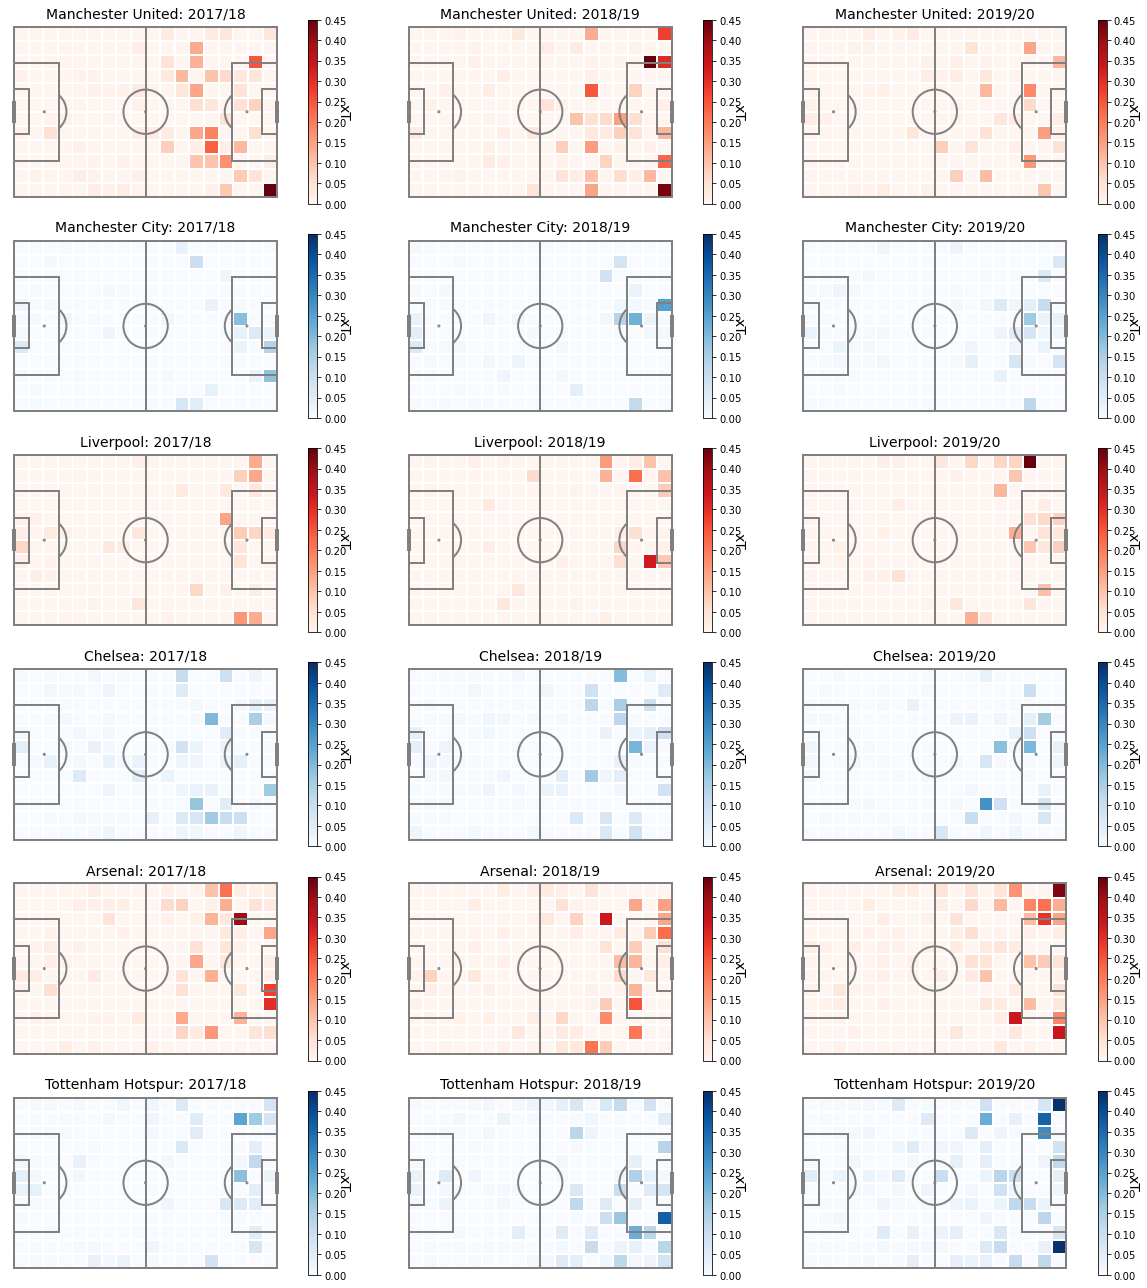

In [463]:
%%time

bins = (18,12)

pitch = mpl_pitch.Pitch(layout=(6, 3), pitch_type='opta', figsize=(18,18), pitch_color='white', line_zorder=2, line_color='gray')
fig, axs = pitch.draw()

vmax_override = 0.45

for ax, p in zip(axs.flat, lst_plots):
    
    team_id, season, c = p

    team_name = teams.loc[teams['homeTeamId'] == team_id, 'homeTeamName'].values[0]

    other_team_ids = df_matches.loc[(df_matches['seasonIndex'] == season) & (df_matches['homeTeamId'] == team_id), 'awayTeamId'].drop_duplicates().values

    # dataframe: matchId | homeTeamId | awayTeamId
    df_season_matches = df_matches.loc[df_matches['seasonIndex'] == season, ['matchId','homeTeamId','awayTeamId']].reset_index(drop=True)

    # code could be tidier but in a rush...
    season_name = df_matches.loc[df_matches['seasonIndex'] == season].reset_index(drop=True).season.values[0]

    # dict: {matchId: [home, away]}
    dic_matches = {i:[j,k] for i,j,k in zip(df_season_matches.matchId,df_season_matches.homeTeamId,df_season_matches.awayTeamId)}

    # looping through the matches
    vs_delta = np.zeros((bins[1], bins[0]))

    for opp_team_id in other_team_ids:

        # each opposition team will have two grids to store the xT counts
        vs_team = np.zeros((bins[1], bins[0]))
        vs_other = np.zeros((bins[1], bins[0]))

        # getting lists of match ids for the other teams, separating out the matches vs inter and the matches vs other teams
        ## getting the frequencies, too, as we'll use those to average things out later
        opp_team_matches_vs_team = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and team_id in dic_matches[i]]
        freq_vs_team = len(opp_team_matches_vs_team)

        opp_team_matches_vs_other = [i for i in dic_matches.keys() if opp_team_id in dic_matches[i] and team_id not in dic_matches[i]]
        freq_vs_other = len(opp_team_matches_vs_other)

        ## starting with 
        for match_id in opp_team_matches_vs_team:
            df_xT_match =  df_opta_m.loc[(df_opta_m['matchId'] == match_id) & (df_opta_m['playerTeamId'] == opp_team_id)].copy()
            vs_team += pitch.bin_statistic(df_xT_match.x1, df_xT_match.y1, df_xT_match.xT, statistic='sum', bins=bins)['statistic']

        for match_id in opp_team_matches_vs_other:
            df_xT_match =  df_opta_m.loc[(df_opta_m['matchId'] == match_id) & (df_opta_m['playerTeamId'] == opp_team_id)].copy()
            vs_other += pitch.bin_statistic(df_xT_match.x1, df_xT_match.y1, df_xT_match.xT, statistic='sum', bins=bins)['statistic']

        # calculating averages
        mean_vs_team = vs_team / freq_vs_team
        mean_vs_other = vs_other / freq_vs_other

        # adding to delta
        vs_delta += (mean_vs_team - mean_vs_other)

    # providing overlay - the statistics here don't matter - we'll override these soon
    team_bin_statistic = pitch.bin_statistic(df_xT_match.x2, df_xT_match.y2, df_xT_match.xT, statistic='sum', bins=bins)

    # overriding single match with the aggregated delta
    team_bin_statistic['statistic'] = vs_delta

    # setting the colour scale
    vmax = team_bin_statistic['statistic'].max()
    vmin = 0

    # plotting the heatmap
    team_pcm = pitch.heatmap(team_bin_statistic, ax=ax, cmap=c, edgecolors='white', vmin=vmin, vmax=vmax_override)
    team_cbar = fig.colorbar(team_pcm, ax=ax)
    team_cbar.set_label('xT', rotation=270, fontsize=14)
    ax.set_title(f'{team_name}: {season_name}', x=0.5, y=0.98, fontsize=14, color='black')

fig.savefig('Top_6_Delta_xT.png', transparent=True, dpi=300)
